<a href="https://colab.research.google.com/github/watanabe-gk/study_gpt/blob/main/%E4%BA%8B%E5%89%8D%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title モジュールのインストール
!pip install -qq datasets==2.18
!pip install -qq mecab-python3==1.0.8
!pip install -qq unidic-lite
!git clone https://github.com/Michi-123/whiteGPT.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Cloning into 'whiteGPT'...
remote: Enumerating objects: 1255, done.
remote: Counting objects: 100% (91/91), done.
remote: C

<h1><font color="cyan">None</font>の部分を書き換えていきましょう</h1>

In [2]:
#@title ライブラリーのインポート
import math
import torch
import torch.nn as nn
import torch.optim as optim # 最適化モジュール
from matplotlib import pyplot as plt # グラフの描画
import MeCab # 形態素解析

In [3]:
#@title Google Driveのマウント
# from google.colab import drive
# drive.mount('/content/drive')

GPUの使用を判定

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
#@title MeCabの利用 (日本語を形態素解析するプログラム)
tagger = MeCab.Tagger("-Owakati")

In [6]:
# @title Exercise
tagger.parse('私は昨日公園にいきました')

'私 は 昨日 公園 に いき まし た \n'

In [7]:
# @title 青空文庫データセットの利用
from datasets import load_dataset
ds = load_dataset('globis-university/aozorabunko-clean')
ds = ds.filter(lambda row: row['meta']['文字遣い種別'] == '新字新仮名')  # 新字新仮名に限定

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/16951 [00:00<?, ? examples/s]

In [8]:
authors = ['夏目'] #@param
# titles = [ 'こころ', '三四郎' ,'それから', '坊っちゃん']#@param
titles = ['文鳥', '正岡子規']#@param
corpus = ''
for book in ds['train']:
    title = book['meta']['作品名']
    author = book['meta']['姓']
    # if author in authors:
    if title in titles and author in authors:
        print(author, title)
        text = book['text'] # 本文
        text = ''.join(text.split()) # Clean up
        text = tagger.parse(text) # 形態素解析
        corpus += text

print(corpus[:100])

夏目 文鳥
夏目 正岡子規
十 月 早稲田 に 移る 。 伽藍 の よう な 書斎 に ただ 一人 、 片づけ た 顔 を 頬杖 で 支え て いる と 、 三重吉 が 来 て 、 鳥 を 御 飼い なさい と 云う 。 飼っ 


# Hyper parameter

In [9]:
# @markdown Model parameters

# 512 token GPT1
# 10
context_size = 10 # @param {type: "integer"}

# 768 GPT1 (512+256)
# 192
d_model = 64 #@param {type: "integer"}

# 12 GPT1
# 3
n_head = 2 #@param {type: "integer"}

# 12 layer in  GPT1
# 6
n_block = 3 #@param {type: "integer"}

# @markdown Train parameters
# 64 GPT1
# 64
batch_size = 64  #@param {type: "integer"}

# 2.5e-4
# 0.00025
leraning_rate = 0.00025  #@param {type: "number"}

# 100 GPT1
epoch_num = 150 #@param {type: "integer"}

# pre-trained.pkl
pre_trained_model_path = 'pre-trained.pkl' #@param {type: "string"}

In [10]:
# ハイパーパラメータの検証
if d_model % n_head != 0:
    print("埋め込みベクトルの次元はヘッドの数で割り切れる必要があります")
    raise ValueError("d_model must be divisible by n_head")

# インスタンス化

In [11]:
from whiteGPT import GPT, create_attention_mask # 完成コードの利用
from whiteGPT import DataLoader, Evaluate
from whiteGPT import JpTextDataset as Dataset

In [12]:
from random import shuffle
# Dataset と DataLoader
dataset = Dataset(corpus, context_size)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [13]:
# マスク関数
mask = create_attention_mask(context_size).to(device)

In [14]:
# 評価モジュールの利用
evaluate = Evaluate(dataset, context_size)

In [15]:
# 語彙数の取得
vocab_size = len(dataset.vocab)
vocab_size

1596

In [16]:
# GPTモデルの作成とデバイス対応
model = GPT(vocab_size, context_size, d_model, n_head, n_block).to(device)

In [17]:
# クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()
# 最適化モジュールの利用
optimizer = optim.Adam(model.parameters(), lr=leraning_rate)

In [18]:
is_load_model = False # @param{type:"boolean"}
if is_load_model:
    model.load_state_dict(torch.load(pre_trained_model_path, map_location=device))
    print('ok')

# 学習

In [19]:
#@title 初期化
start_epoch = 0
history = {"train_loss": []}
attn_list = [] # 潜在空間の可視化

epoch:1  index:148 loss:6.635011
source て 裂い て 捨て た 。 翌日 文鳥 が また 
target 鳴か
output 。

epoch:2  index:148 loss:5.483030
source が する 。 その 音 が 面白い 。 静か に 
target 聴い
output 。

epoch:3  index:148 loss:5.462523
source で も 縁側 へ 出る 時 は 、 必ず 籠 
target の
output 。

epoch:4  index:148 loss:5.458774
source を 突い た まま で 、 むにゃむにゃ 云っ てる うち 
target に
output 。

epoch:5  index:148 loss:5.457585
source 。 飛び込ん だ 時 は 尾 も 余り 、 頭 
target も
output て

epoch:6  index:148 loss:5.456356
source もの を 呼ん で さ せる 事 も ある 。 
target 自分
output 。



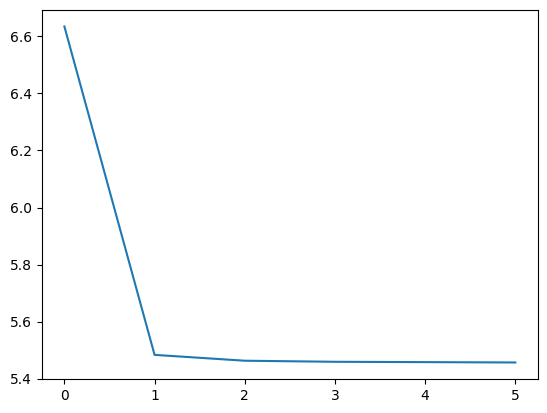

epoch:7  index:148 loss:5.456108
source まま 、 留り 木 の 上 から 、 のめり そう 
target に
output 。

epoch:8  index:148 loss:5.455022
source が 似 た ところ も あっ た し 、 又 
target 半分
output 。

epoch:9  index:148 loss:5.451572
source 上 に じっと 留っ て いる 。 よく 見る と 
target 足
output 。

epoch:10  index:148 loss:5.427569
source 漆 は ね 、 先生 、 日向 へ 出し て 
target 曝し
output 。

epoch:11  index:148 loss:5.346372
source たまら ない 。 それ から 其 『 月 の 都 
target 』
output た



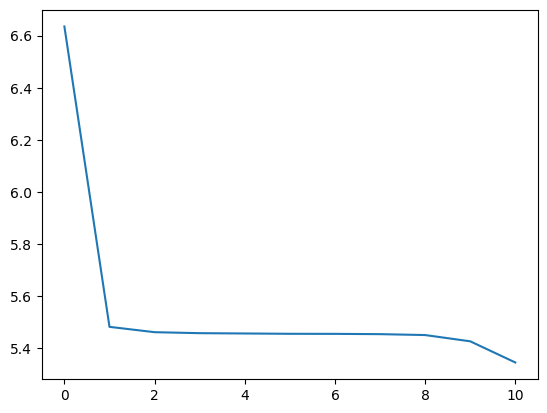

epoch:12  index:148 loss:5.204264
source た 。 如 露 の 水 が 尽きる 頃 に 
target は
output 。

epoch:13  index:148 loss:5.038546
source 聞い たら さぞ 喜ぶ だろう と 思う ほど な 美い 
target 声
output て

epoch:14  index:148 loss:4.855291
source 真白 に 見える 。 籠 の 中 に うずくまっ て 
target い
output 、

epoch:15  index:148 loss:4.680982
source 縁 に 置い て 、 上 から こごん で 籠 
target の
output て

epoch:16  index:148 loss:4.528030
source 。 自分 が 紫 の 帯 上 で いたずら を 
target し
output 、



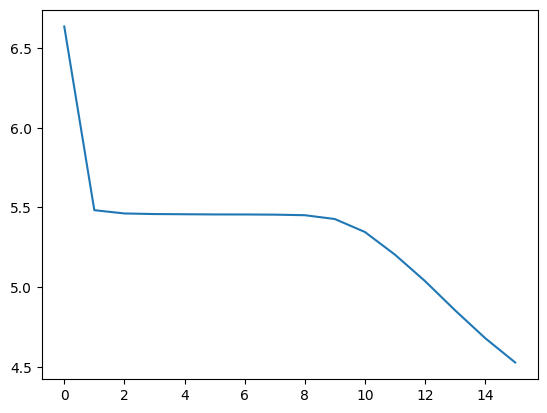

epoch:17  index:148 loss:4.381699
source て おい た 。 三重吉 は にやにや し て いる 
target 。
output 。

epoch:18  index:148 loss:4.249247
source 背負い込ん だ 心持 は 、 少し 寒かっ た が 眠っ 
target て
output の

epoch:19  index:148 loss:4.120063
source 頻り に 演説 など を も やっ た 。 敢て 
target 謹聴
output は

epoch:20  index:148 loss:3.999241
source 、 これ を 投函 し て 来い 、 そう し 
target て
output て

epoch:21  index:148 loss:3.875728
source と 云っ て 帰っ た 。 自分 は 伽藍 の 
target よう
output も



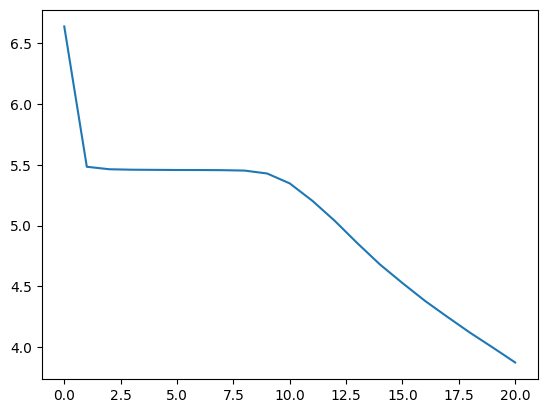

epoch:22  index:148 loss:3.757692
source 中 へ 餌 を 入れ て 、 もう 一 つ 
target に
output の

epoch:23  index:148 loss:3.644214
source なら ない 。 枕元 に ある 新聞 を 手 に 
target 取る
output 上

epoch:24  index:148 loss:3.532976
source おい て 、 急い で 餌 と 水 を 易え 
target て
output て

epoch:25  index:148 loss:3.412537
source 食う 。 まだ 他 の 御 馳走 も 取寄せ て 
target 食っ
output い

epoch:26  index:148 loss:3.310085
source 一 本 出し た 。 自分 は 戸 を 閉 
target てて
output の



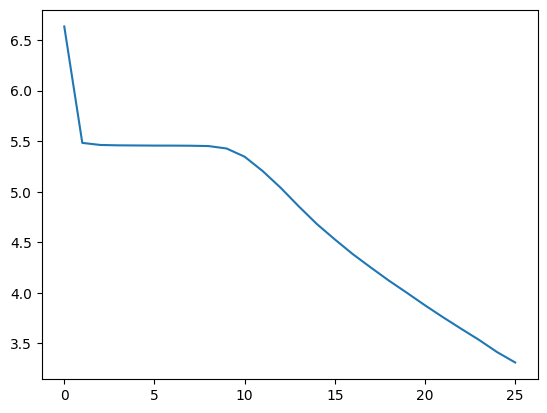

epoch:27  index:148 loss:3.205834
source 一 本 ふかし た 。 この 一 本 を ふかし 
target て
output て

epoch:28  index:148 loss:3.089741
source を 食う 。 いっしょ に 晩飯 を 食う 。 その 
target 上
output 文鳥

epoch:29  index:148 loss:2.989055
source だ と 云う 。 これ は 少し 手数 が 掛る 
target な
output て

epoch:30  index:148 loss:2.885871
source 。 鮭 を 止め て 近 処 の 西洋 料理 
target 屋
output の

epoch:31  index:148 loss:2.786922
source の 上 に 卸し た 。 そう し て 、 
target 烈しく
output 烈しく



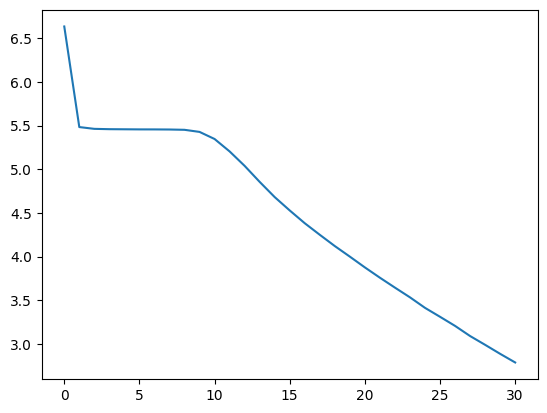

epoch:32  index:148 loss:2.688635
source ビション が あっ た 。 それ で 頻り に 演説 
target など
output に

epoch:33  index:148 loss:2.590576
source 。 あの 時分 は 『 月 の 都 』 と 
target いう
output 真中

epoch:34  index:148 loss:2.490407
source 四 尺 ばかり こっち から 見る と 少し も 動か 
target ない
output を

epoch:35  index:148 loss:2.417085
source 浸し て 、 時々 は 白い 翼 を 左右 に 
target ひろげ
output ひろげ

epoch:36  index:148 loss:2.340319
source を 乱し て 騒い だ 。 小い 羽根 が 一 
target 本
output 度



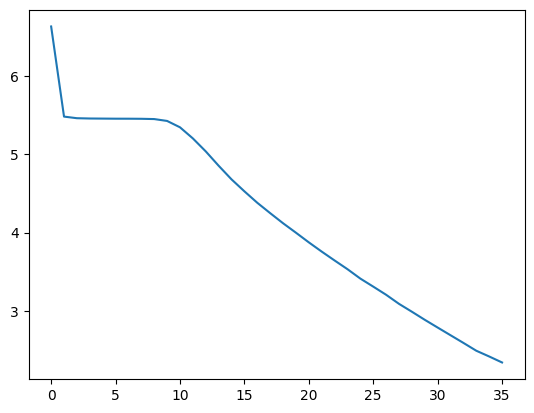

epoch:37  index:148 loss:2.252309
source 子供 が 文鳥 を 埋る ん だ 埋る ん だ 
target と
output 正岡

epoch:38  index:148 loss:2.186582
source と その 手つき まで し て 見せ た が 、 
target こう
output こう

epoch:39  index:148 loss:2.136148
source で 見る 。 それ で も 筆 と 紙 が 
target いっしょ
output いっしょ

epoch:40  index:148 loss:2.066813
source 前 へ 伸し た か と 思っ たら 、 白い 
target 羽根
output 羽根

epoch:41  index:148 loss:2.015756
source の よう に 静か で ある 。 さすが に 文鳥 
target は
output を



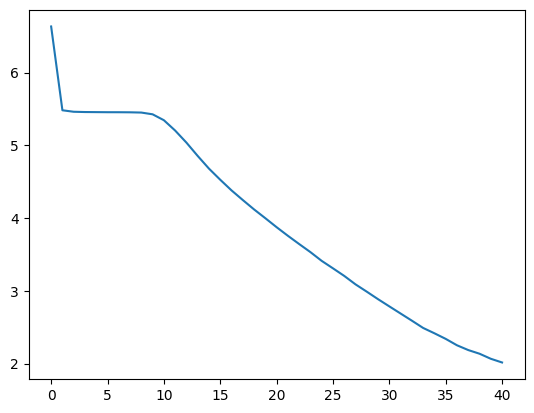

epoch:42  index:148 loss:1.967416
source 。 左右 に 振り 蒔く 粟 の 珠 も 非常 
target に
output に

epoch:43  index:148 loss:1.917349
source この 煙 の 中 に 、 首 を すくめ た 
target 、
output 。

epoch:44  index:148 loss:1.870488
source 。 水 も 全く 濁っ て しまっ た 。 書物 
target を
output を

epoch:45  index:148 loss:1.814765
source と 、 公 札 の 表 に は 、 この 
target 土手
output 土手

epoch:46  index:148 loss:1.777693
source 自分 は 静か に 鳥籠 を 箱 の 上 に 
target 据え
output 、



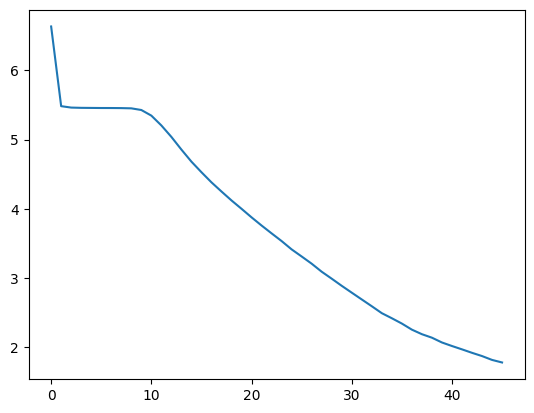

epoch:47  index:148 loss:1.738567
source に 居る 。 其 うち 松山 中 の 俳句 を 
target 遣る
output 遣る

epoch:48  index:148 loss:1.705459
source に 静か で ある 。 さすが に 文鳥 は 軽い 
target もの
output と

epoch:49  index:148 loss:1.670680
source を 御 飼い なさい と 云う 。 飼っ て も 
target いい
output ば

epoch:50  index:148 loss:1.624574
source た 。 翌日 文鳥 が また 鳴か なく なっ た 
target 。
output 。

epoch:51  index:148 loss:1.590885
source た 。 たいてい は 狭い 籠 を 苦 に も 
target し
output 思っ



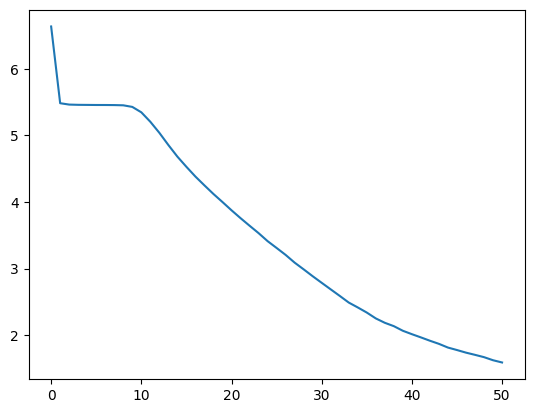

epoch:52  index:148 loss:1.558132
source 這入っ た 。 十 畳 の 真中 へ 鳥籠 を 
target 卸し
output 卸し

epoch:53  index:148 loss:1.527745
source 向け て 、 籠 の 外 に いる 自分 を 
target 見上げ
output 見上げ

epoch:54  index:148 loss:1.503283
source た 。 おおかた 頬杖 に 愛想 を 尽かし た ん 
target だろう
output か

epoch:55  index:148 loss:1.473208
source から 籠 を 出し て やっ た の は 、 
target やっぱり
output やっぱり

epoch:56  index:148 loss:1.435913
source 。 細い 足 を 壺 の 縁 へ 懸け て 
target 、
output 、



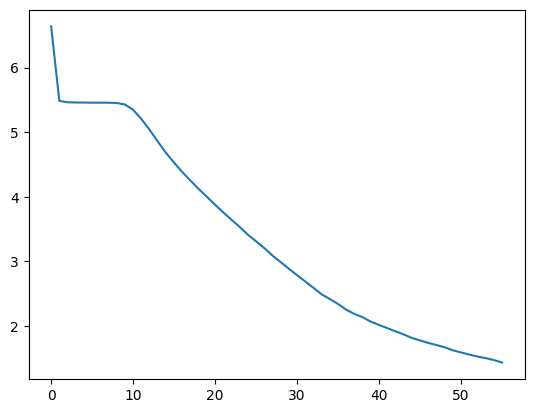

epoch:57  index:148 loss:1.406346
source を そろり と 上 へ 押し上げ た 。 同時 に 
target 左
output 左

epoch:58  index:148 loss:1.379709
source 他 、 半分 は 性質 が 似 た ところ も 
target あっ
output あっ

epoch:59  index:148 loss:1.349820
source を 覗き込ん だ 。 自分 は 顔 を 洗い に 
target 風呂場
output 風呂場

epoch:60  index:148 loss:1.333697
source なかっ た 。 依然 と し て 急ぐ 小説 を 
target 書い
output し

epoch:61  index:148 loss:1.302562
source 頻り に ひっくりかえし て い た 。 幼稚 な 正岡 
target が
output が



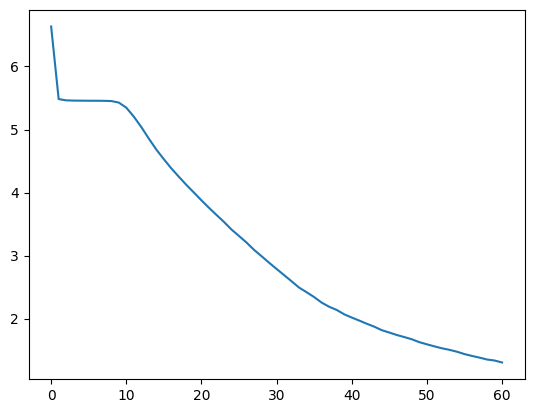

epoch:62  index:148 loss:1.270783
source なん で も 僕 が 松山 に 居 た 時分 
target 、
output と

epoch:63  index:148 loss:1.241103
source 、 人 の 金 で も 自分 の 金 で 
target も
output 、

epoch:64  index:148 loss:1.224384
source 、 こちら から も 遣っ た 。 今 は 残っ 
target て
output て

epoch:65  index:148 loss:1.205874
source 、 つい 聞い て おか なかっ た 。 自分 は 
target やむ
output やむ

epoch:66  index:148 loss:1.178739
source 書い て 来 た 。 何 で も 僕 は 
target 教育
output 教育



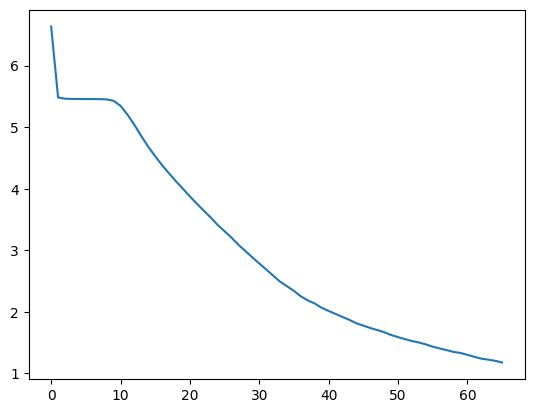

epoch:67  index:148 loss:1.147056
source が 文鳥 は けっして 近づか ない 。 少し 無 遠慮 
target に
output に

epoch:68  index:148 loss:1.124081
source に 入れ て やる ん だ と 云う 。 籠 
target が
output は

epoch:69  index:148 loss:1.105757
source し た 。 鮭 を 止め て 近 処 の 
target 西洋
output 西洋

epoch:70  index:148 loss:1.072690
source た 。 発句 も 近来 漸く 悟っ た と か 
target いっ
output いっ

epoch:71  index:148 loss:1.068505
source から 其 『 月 の 都 』 を 露伴 に 
target 見せ
output 見せ



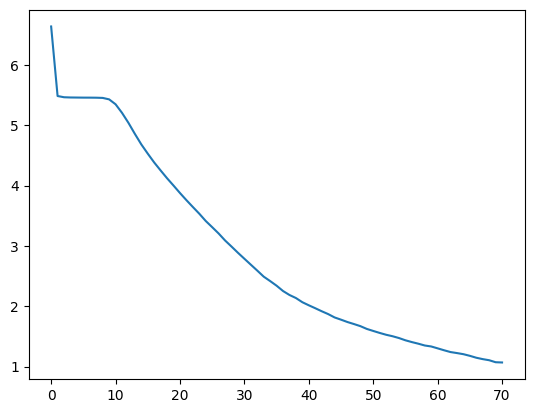

epoch:72  index:148 loss:1.043548
source 水 入 の 直径 は 一寸 五 分 ぐらい に 
target 過ぎ
output 過ぎ

epoch:73  index:148 loss:1.025511
source ぐらい する と 云う 段 に なっ て 、 急 
target に
output に

epoch:74  index:148 loss:0.994000
source 顔 も し なかっ た 。 籠 が 明るい 所 
target へ
output へ

epoch:75  index:148 loss:0.962867
source か 。 ハヽヽヽ 。 そう だ なあ 。 なん で 
target も
output も

epoch:76  index:148 loss:0.953905
source を 一 袋 出し た 。 これ を 毎朝 食わ 
target せ
output せ



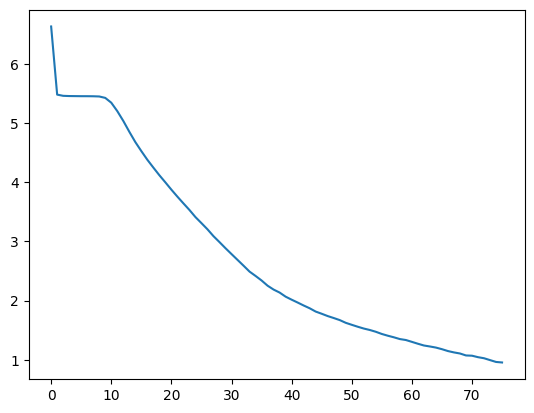

epoch:77  index:148 loss:0.926661
source 。 一体 正岡 は 無暗 に 手紙 を よこし た 
target 男
output 。

epoch:78  index:148 loss:0.912367
source て い た の で 、 話す に 足る と 
target で
output が

epoch:79  index:148 loss:0.892707
source やら なけれ ば なら ない 。 と その 手つき まで 
target し
output に

epoch:80  index:148 loss:0.868151
source 、 そんな 所 へ 嫁 に やる の は 行末 
target よく
output よく

epoch:81  index:148 loss:0.847728
source 出し て 見る 事 が ある が 文鳥 は けっして 
target 近づか
output 近づか



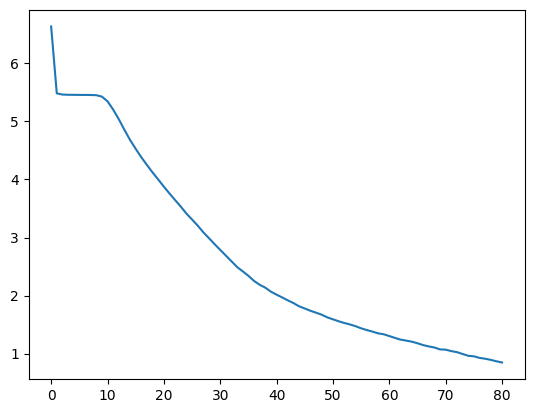

epoch:82  index:148 loss:0.835400
source 振り廻す もの だ から 、 僕 など は 恐れ を 
target 為し
output 為し

epoch:83  index:148 loss:0.810416
source 自分 は 籠 の 傍 に 立っ て 、 じっと 
target 文鳥
output この

epoch:84  index:148 loss:0.803758
source いる 時分 で あっ た 。 飯 と 飯 の 
target 間
output 間

epoch:85  index:148 loss:0.781335
source も 文鳥 の 世話 を し なけれ ば なら なく 
target なる
output なる

epoch:86  index:148 loss:0.768371
source も ずっと 低い 。 庭 下駄 を 穿い て 、 
target 日影
output 日影



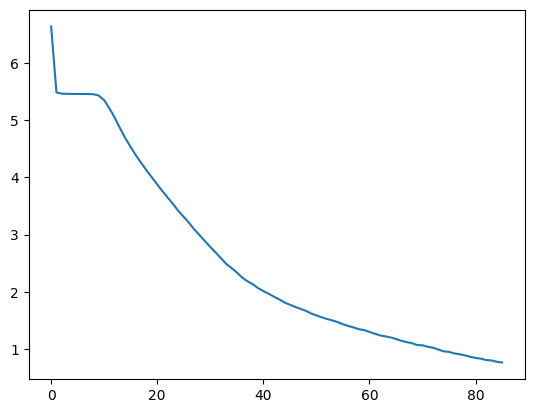

epoch:87  index:148 loss:0.746307
source と 載せ た 顎 を 一応 撮ん で 見る 。 
target それ
output それ

epoch:88  index:148 loss:0.728662
source の 長い 、 背 の すらり と し た 、 
target ちょっと
output ちょっと

epoch:89  index:148 loss:0.725421
source に 三重吉 は 黙っ て しまっ た 。 おおかた 頬杖 
target に
output を

epoch:90  index:148 loss:0.705677
source だ から 、 何 を 飼う の か ね と 
target 聞い
output 聞い

epoch:91  index:148 loss:0.694974
source 依然 と し て 寝坊 を する 。 一 度 
target 家
output 家



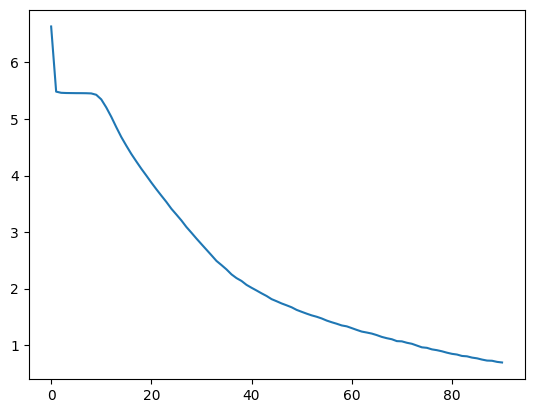

epoch:92  index:148 loss:0.676839
source 受合っ て 帰っ て 行っ た 。 自分 は また 
target 籠
output 籠

epoch:93  index:148 loss:0.654556
source あろう 。 それ から 大 に 近よっ て 来 た 
target 。
output 。

epoch:94  index:148 loss:0.662672
source 大変 文鳥 に 親切 を 極め て いる 。 そこ 
target で
output で

epoch:95  index:148 loss:0.635011
source 真中 に 床 を 展べ て 冷 か に 寝 
target た
output た

epoch:96  index:148 loss:0.624232
source に 文鳥 は 軽い もの だ 。 何 だ か 
target 淡雪
output 淡雪



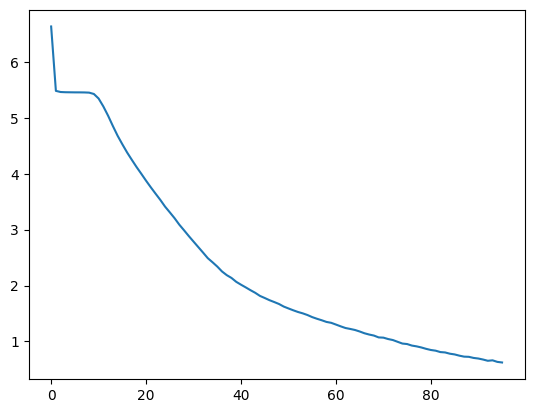

epoch:97  index:148 loss:0.610564
source いう 。 僕 が 行っ て ノート を 大略 話し 
target て
output て

epoch:98  index:148 loss:0.592297
source その 間 に は 折々 千代 千代 と 云う 声 
target も
output が

epoch:99  index:148 loss:0.588142
source で 試験 前 に なる と 僕 に 来 て 
target 呉れ
output 呉れ

epoch:100  index:148 loss:0.573389
source 直線 に 伸ばし て い た 。 自分 は 籠 
target の
output の

epoch:101  index:148 loss:0.551655
source て 時々 は 首 を 伸し て 籠 の 外 
target を
output を



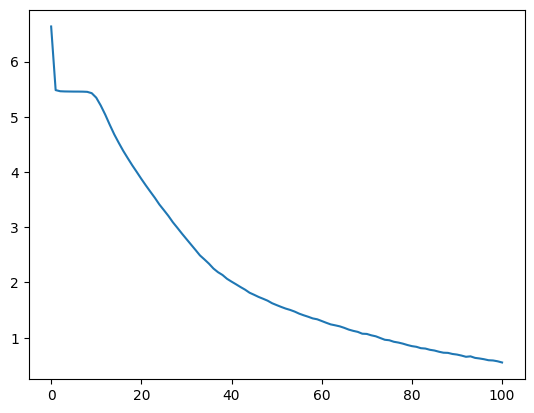

epoch:102  index:148 loss:0.557160
source あっ て 遅く 帰っ たら 、 冬 の 月 が 
target 硝子
output 硝子

epoch:103  index:148 loss:0.534227
source 、 さっそく 万事 を 三重吉 に 依頼 する 事 に 
target し
output ある

epoch:104  index:148 loss:0.528863
source 二三 度 竪 横 に 向け直し た 。 やがて 一団 
target の
output の

epoch:105  index:148 loss:0.509635
source た 頬 を 上げ て 、 繊 い 手 を 
target 額
output 額

epoch:106  index:148 loss:0.508057
source 時 頃 で ある 。 玄関 へ 外套 を 懸け 
target て
output て



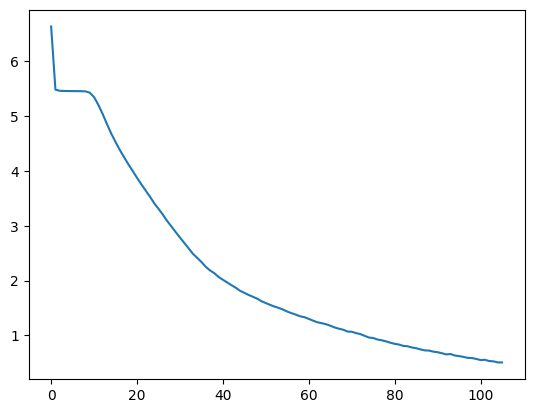

epoch:107  index:148 loss:0.503811
source 露伴 も いっ た と か 言っ て 、 自分 
target も
output は

epoch:108  index:148 loss:0.484733
source 気色 は さらに なかっ た 。 自分 の 指 から 
target じか
output じか

epoch:109  index:148 loss:0.479994
source まで 浸し て 、 時々 は 白い 翼 を 左右 
target に
output に

epoch:110  index:148 loss:0.474381
source 前 に 火鉢 を 置い て 当る の じゃ と 
target いう
output いう

epoch:111  index:148 loss:0.459510
source そう し て その 鳥 を そっち へ 持っ て 
target 行け
output 行け



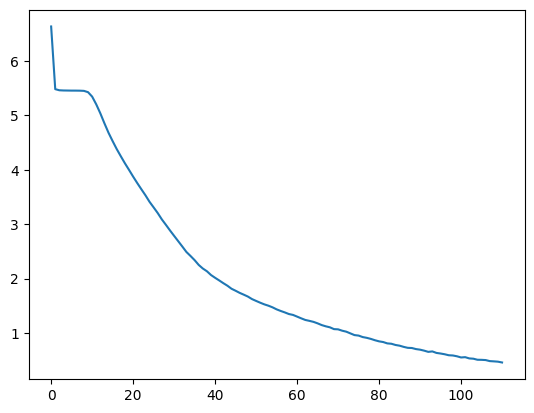

epoch:112  index:148 loss:0.439421
source 鳥籠 の 桟 に かじりつい て い た 。 自分 
target は
output は

epoch:113  index:148 loss:0.439818
source で ある 。 餌 壺 に は まだ 粟 が 
target 八
output 八

epoch:114  index:148 loss:0.436042
source へ 出せ など と 云う 。 その くせ 寒い の 
target で
output で

epoch:115  index:148 loss:0.427148
source は 幾 粒 だ か 分ら ない 。 それ で 
target も
output も

epoch:116  index:148 loss:0.403189
source ついで を もっ て 、 冷たい 縁 を 素足 で 
target 踏み
output 踏み



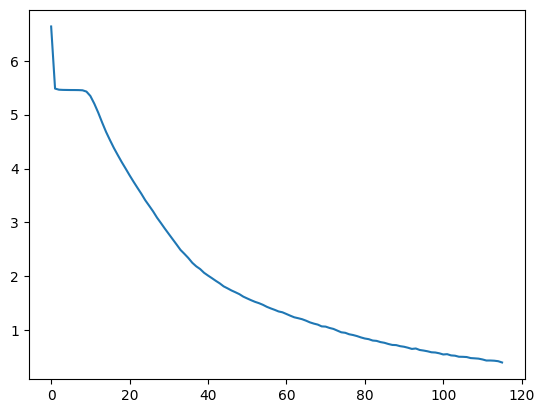

epoch:117  index:148 loss:0.404180
source 持っ て 来 て 、 彼 は ハルトマン の 哲学 
target 書
output 書

epoch:118  index:148 loss:0.396007
source 。 三重吉 は 嘘 を 吐い た に 違 ない 
target 。
output 。

epoch:119  index:148 loss:0.394386
source 定めし 鳴き 善かろう と 思う くらい で あっ た 。 
target 三重吉
output 三重吉

epoch:120  index:148 loss:0.385473
source 覚え て いる 。 それ から 帰り に 奈良 へ 
target 寄っ
output 寄っ

epoch:121  index:148 loss:0.373515
source 水 の 壺 を 留り 木の間 に ようやく 置く や 
target 否
output 否



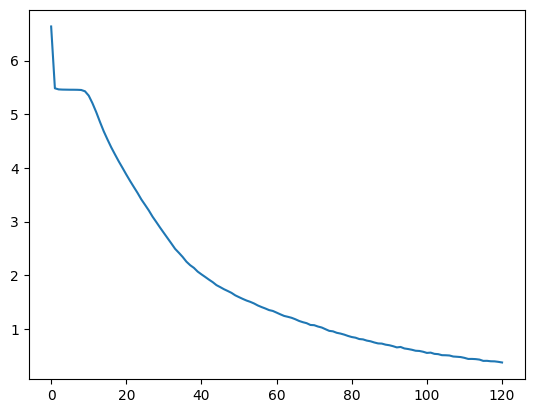

epoch:122  index:148 loss:0.361217
source へ 廻っ て 、 戸棚 を 明け て 、 昨夕 
target 三重
output 三重

epoch:123  index:148 loss:0.370488
source と 云う 。 安い なあ 豊隆 と 云っ て いる 
target 。
output 。

epoch:124  index:148 loss:0.350248
source 。 二十 円 に 比べ て 安い の は 無論 
target で
output で

epoch:125  index:148 loss:0.345669
source た 。 そう し て 、 烈しく 手 を 鳴らし 
target た
output た

epoch:126  index:148 loss:0.341558
source 支那 から 帰っ て 来 て 僕 の ところ へ 
target 遣っ
output 入れ



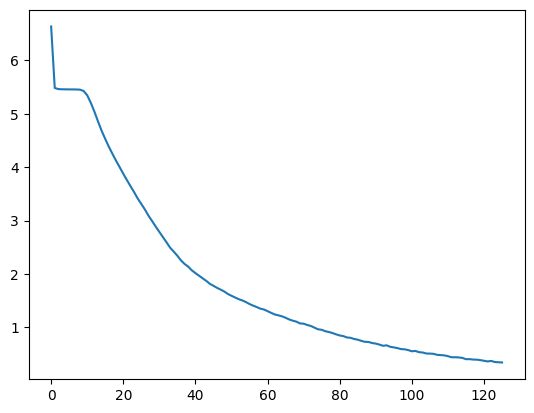

epoch:127  index:148 loss:0.325036
source あちら 、 こちら と 飛び移っ て いる 。 そう し 
target て
output て

epoch:128  index:148 loss:0.325172
source を し た の は 縁談 の きまっ た 二三 
target 日
output 日

epoch:129  index:148 loss:0.323790
source 筆 と 紙 が いっしょ に なら ない 時 は 
target 、
output 、

epoch:130  index:148 loss:0.312923
source 。 其 うち 覚え て いる 事 を 一 つ 
target 二
output に

epoch:131  index:148 loss:0.303462
source こう いっさい 万事 を 調え て おい て 、 実行 
target を
output を



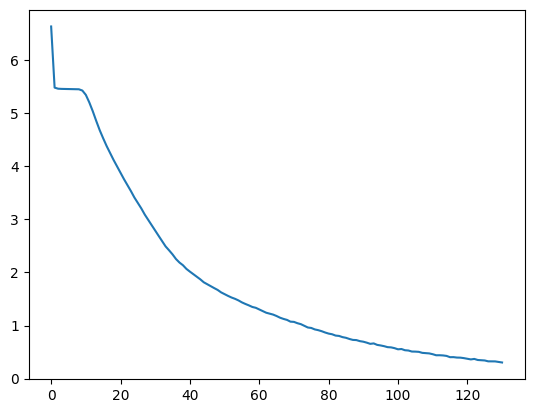

epoch:132  index:148 loss:0.301580
source て 、 ここ へ 置き ます から と 云っ て 
target 帰っ
output 帰っ

epoch:133  index:148 loss:0.296949
source が ぽい と 留り 木 の 上 を 抜け出し た 
target 。
output 。

epoch:134  index:148 loss:0.289591
source 。 やがて 一団 の 白い 体 が ぽい と 留り 
target 木
output 木

epoch:135  index:148 loss:0.285344
source た 粟 の 袋 を 出し て 、 餌 壺 
target の
output へ

epoch:136  index:148 loss:0.270431
source た 。 自分 は 床 の 上 に 起き直っ た 
target 。
output 。



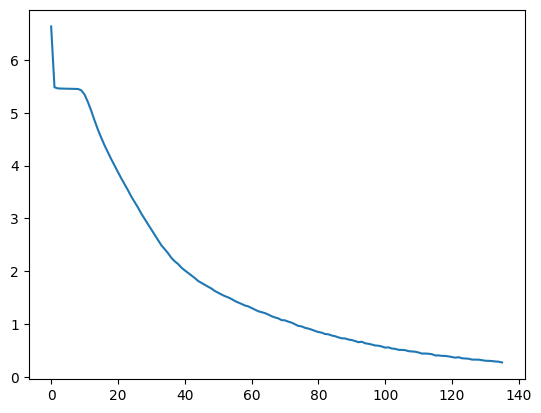

epoch:137  index:148 loss:0.269411
source に 寄っ て 一 本 に なる 。 と 思う 
target と
output と

epoch:138  index:148 loss:0.258824
source 木枯 が 吹い て い た 。 夕方 に は 
target 文鳥
output 文鳥

epoch:139  index:148 loss:0.267596
source それ で も 黙っ て いる 。 自分 は 机 
target の
output の

epoch:140  index:148 loss:0.257577
source た 。 やがて 一団 の 白い 体 が ぽい と 
target 留り
output 留り

epoch:141  index:148 loss:0.241510
source た 。 寝る 時 硝子 戸 から 外 を 覗い 
target たら
output たら



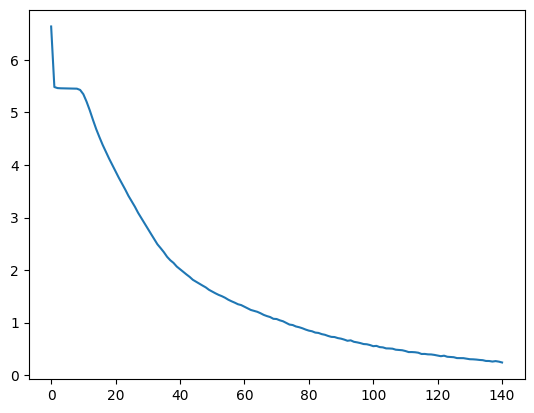

epoch:142  index:148 loss:0.239744
source へ 持っ て 行っ た 。 水 も 易え て 
target やっ
output やっ

epoch:143  index:148 loss:0.242548
source ん だ そう だ 。 現に 三重吉 の 飼っ て 
target い
output い

epoch:144  index:148 loss:0.243374
source 自分 は そっと 書斎 へ 帰っ て 淋しく ペン を 
target 紙
output 紙

epoch:145  index:148 loss:0.234162
source の 中 に うずくまっ て い なけれ ば 鳥 と 
target は
output は

epoch:146  index:148 loss:0.232321
source いったん 行け ば むやみ に 出 られる もの じゃ ない 
target 。
output 。



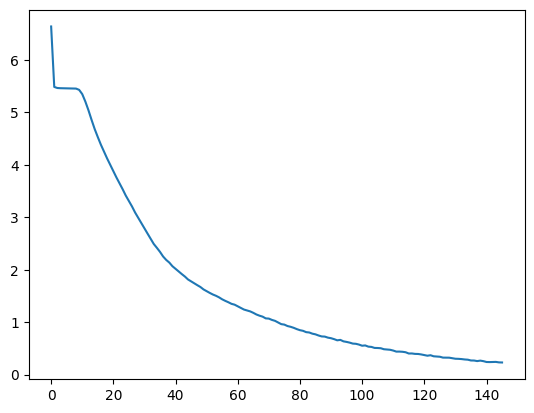

epoch:147  index:148 loss:0.219694
source は うん 安い と 云っ て いる 。 自分 は 
target 安い
output 安い

epoch:148  index:148 loss:0.221546
source 三重吉 は にやにや し て いる 。 それ から 全体 
target どこ
output どこ

epoch:149  index:148 loss:0.215339
source 明るく 見える なか に 、 鳥籠 が しんと し て 
target 、
output 、

epoch:150  index:148 loss:0.219841
source 蒼い 木賊 の 一 株 と 並ん で 立っ て 
target いる
output いる



In [20]:
#@title Train

# Epoch数まで繰り返し
for epoch in range(start_epoch, epoch_num):

    # 損失の累計をリセット
    running_loss = 0.0

    # 学習モードに変更
    model.train()

    # 学習データセット全体をバッチ単位で処理
    for i, batch in enumerate(train_dataloader):

        # 入力元データと教師データ
        source = batch['source'].to(device)
        target = batch['target'].to(device).view(-1)

        # 勾配のリセット
        optimizer.zero_grad()

        # 推論
        outputs, w = model(source, mask)

        # 損失計算
        loss = criterion(outputs, target)

        # 誤差逆伝播
        loss.backward()

        # 学習パラメータの更新
        optimizer.step()

        # 損失の累積
        running_loss += loss.item()

        # print( i , len(train_dataloader))

    # 損失の履歴を作成
    train_loss = running_loss / len(train_dataloader)
    history["train_loss"].append(train_loss)

    # 開始epochの更新
    start_epoch = epoch

    # 損失の確認
    if epoch % 1 == 0:
        print(f"epoch:{epoch+1}  index:{i+1} loss:{train_loss:.6f}")
        evaluate.predict(source, target, outputs)

    # グラフの描画
    if epoch % 5 == 0 and epoch != 0:
        plt.plot(history['train_loss'])
        plt.show()

    # モデルの保存
    if epoch % 10 == 0 and epoch != 0:
        torch.save(model.state_dict(), pre_trained_model_path )


    ## 可視化の処理（Epochごとに重みを格納します）
    # 評価モードに変更
    model.eval()
    # 推論
    _, w = model(source)
    # Attentionの潜在空間の履歴を作成
    attn_list.append(w[0].detach())

In [21]:
torch.save(model.state_dict(), pre_trained_model_path )

# Test

In [22]:
# モデルの読み込み
model.load_state_dict(torch.load(pre_trained_model_path))
# 評価モードに設定
_ = model.eval()

<ipython-input-22-75db2e08215f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pre_trained_model_path))


https://www.aozora.gr.jp/cards/000148/files/753_42587.html

In [23]:
sample_corpus = "何しろ言いだしたものに責任を負わせるのは" #@param{type:"string"}
parsed_corpus = tagger.parse(sample_corpus)
print(sample_corpus)
evaluate.generate(parsed_corpus, model, mask)

何しろ言いだしたものに責任を負わせるのは
のは当然の事だから、さっそく万事を三重吉に依頼する事にした。すると、すぐ金を出せと云う。金はたしかに出した。三重吉はどこで買ったか、七子の三つ折の紙入を懐中していて、人の金でも自分の金でも悉皆この紙入の中に入れる癖がある。自分は三重吉に五円札をたしかにこの紙入の底へ押し込んだのを目撃していた。文鳥はやっと安心寒い手をまた書斎へ入れた。縁側がちょっと露の出る。よく其手を白い時分、東京へ出て這入る書斎へ這入る神田日眼を覚めるとして、二三行書き出すのも水が急に自分の声を箱に上を手を入れて、左の手を籠の上を翳して、浮かそうしていた。水は自分の方に少しと発達せず、まるでわからん処へ持って来て、彼はハルトマンの哲学書か何かを持ち込み、大分振り廻していた。尤も厚い独逸書で、外国にいる加藤恒忠氏に送って貰ったもので、ろくに読めもせぬものを頻りにひっくりかえしていた。幼稚な正岡が其事も這入っていた。文鳥は自分の方の日がついた。顔をしだいに午飯を家に落ちている。そのうちなは無邪気である。昔紫の帯上でいたずらをした女は襟の長い、背のすらりとした、ちょっと首を曲げて人を見る癖があった。粟はまだある。水もまだある。文鳥は満足している。自分は粟も水も易えずに書斎へ引込んだ。昼過ぎまた縁側へ出た。食後の運動かたがた、五六間の廻り縁を、あるきながら書見するつもりであった。ところが出て見ると粟がもう七分がた尽きている。水も全く濁ってしまった。書物を縁側へ抛り出しておいて、急いで餌を水を易えてやった。次の日もまた遅く起きた。しかも顔を洗って飯を食うまでは縁側を覗かなかった。書斎に帰ってから、あるいは昨日のように、家人が籠を出しておきはせぬか自分がちょっと縁へ顔を